# Compare grouped LSOA boundaries with CCGs

We know that Clinical Commissioning Groups (CCGs) and so Sub-Integrated Care Board Locations (SICBLs) are built up from LSOA boundaries. This notebook checks to see if we can build them up by globbing together LSOA with similar names.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [3]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_tabular = '../data_tabular/ons_data/'
    dir_tabular = '../data_tabular/'
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output = 'output_data'
    dir_output_images = 'output_images'

    # Tabular data:
    sicbl_icb = 'LOC22_ICB22_NHSER22_EN_LU.csv'
    lad_country = 'Local_Authority_District_to_Country_(December_2022)_Lookup_in_the_United_Kingdom.csv'
    sicbl_lad = 'LSOA11_LOC22_ICB22_LAD22_EN_LU.csv'
    ccg_ambo = 'ambulance_service_info_ccg_lookup.csv'
    ccg_sicbl = 'ccg_stp_sicbl_icb.csv'

    # Boundaries data:
    lsoa_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'

    # Output:
    df_output = 'lsoa11_ccg15.csv'
    image_output = 'boundaries_lsoa11glob_ccg15.png'

paths = Paths()

In [38]:
region_code = 'LSOA11CD'

## Import region files

In [4]:
gdf_lsoa = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.lsoa_geojson))
gdf_ccg = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [5]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [6]:
gdf_lsoa.head(3)

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.231, 532162.491 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.250 18..."


Glob together LSOA with similar names:

In [12]:
df_lsoa_names = pd.DataFrame()

df_lsoa_names['name_bits'] = gdf_lsoa['LSOA11NM'].str.split(' ')

In [15]:
df_lsoa_names.explode('name_bits')

,name_bits
0,City
0,of
0,London
0,001A
1,City
...,...
34750,023E
34751,Swansea
34751,025G
34752,Swansea


In [22]:
lsoa_name_bits = df_lsoa_names['name_bits'].to_list()

In [25]:
lsoa_name_bits_without_numbers = [' '.join(bits[:-1]) for bits in lsoa_name_bits]

In [27]:
gdf_lsoa['lsoa_name_without_numbers'] = lsoa_name_bits_without_numbers

In [31]:
gdf_lsoa_glob = gdf_lsoa.dissolve(by='lsoa_name_without_numbers')

In [32]:
gdf_lsoa_glob

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID
lsoa_name_without_numbers,,,,,,,,,,
Adur,"MULTIPOLYGON (((520827.998 105333.998, 520847....",30546,E01031338,Adur 002A,Adur 002A,522875,106278,-0.25610,50.84298,faf6e1fc-00c7-4188-b19f-275ed02db66c
Allerdale,"MULTIPOLYGON (((331958.687 524889.375, 332036....",18537,E01019078,Allerdale 007A,Allerdale 007A,312500,529488,-3.35769,54.65287,8ffa1fc3-f760-4a6d-bebf-c766b05f7bb9
Amber Valley,"POLYGON ((444624.690 350587.218, 444712.406 35...",18857,E01019400,Amber Valley 001A,Amber Valley 001A,441810,356343,-1.37698,53.10267,d28e2227-c106-4317-8412-edc4a28e9ad2
Arun,"MULTIPOLYGON (((488249.800 96080.197, 488240.9...",30588,E01031380,Arun 018A,Arun 018A,491459,98597,-0.70409,50.77973,3ab282c5-01c3-4cd3-83b3-7d86aa9a9c63
Ashfield,"POLYGON ((453560.903 347076.471, 453253.750 34...",27211,E01027925,Ashfield 015A,Ashfield 015A,452776,348922,-1.21442,53.03500,a2faf3d0-35fd-4dd5-813c-a9b73b7ab0c5
...,...,...,...,...,...,...,...,...,...,...
Wychavon,"POLYGON ((409071.804 241728.093, 408869.310 24...",31530,E01032340,Wychavon 013A,Wychavon 013A,405991,244418,-1.91394,52.09808,ea71430f-ea4b-460d-9641-a9fce6f18b51
Wycombe,"POLYGON ((486815.071 186247.332, 486813.309 18...",17318,E01017836,Wycombe 015A,Wycombe 015A,485000,192529,-0.77346,51.62517,4dfc5602-395e-4aa9-bff6-dc049b04765a
Wyre,"MULTIPOLYGON (((349146.414 438455.053, 349192....",24873,E01025541,Wyre 011A,Wyre 011A,333945,444377,-3.00656,53.89135,bf472125-a0fa-4df5-9d1b-4981e590a4bd


Find lsoa centroids:

In [33]:
gdf_lsoa_glob['centroid'] = gdf_lsoa_glob['geometry'].centroid

In [34]:
gdf_lsoa_glob.head(3)

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,centroid
lsoa_name_without_numbers,,,,,,,,,,,
Adur,"MULTIPOLYGON (((520827.998 105333.998, 520847....",30546,E01031338,Adur 002A,Adur 002A,522875,106278,-0.25610,50.84298,faf6e1fc-00c7-4188-b19f-275ed02db66c,POINT (519827.711 106429.863)
Allerdale,"MULTIPOLYGON (((331958.687 524889.375, 332036....",18537,E01019078,Allerdale 007A,Allerdale 007A,312500,529488,-3.35769,54.65287,8ffa1fc3-f760-4a6d-bebf-c766b05f7bb9,POINT (320064.991 534974.789)
Amber Valley,"POLYGON ((444624.690 350587.218, 444712.406 35...",18857,E01019400,Amber Valley 001A,Amber Valley 001A,441810,356343,-1.37698,53.10267,d28e2227-c106-4317-8412-edc4a28e9ad2,POINT (435868.992 348126.255)


Find representative points:

In [35]:
gdf_lsoa_glob['representative_point'] = gdf_lsoa_glob['geometry'].representative_point()

In [36]:
gdf_lsoa_glob.head(3)

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,centroid,representative_point
lsoa_name_without_numbers,,,,,,,,,,,,
Adur,"MULTIPOLYGON (((520827.998 105333.998, 520847....",30546,E01031338,Adur 002A,Adur 002A,522875,106278,-0.25610,50.84298,faf6e1fc-00c7-4188-b19f-275ed02db66c,POINT (519827.711 106429.863),POINT (518068.801 106405.949)
Allerdale,"MULTIPOLYGON (((331958.687 524889.375, 332036....",18537,E01019078,Allerdale 007A,Allerdale 007A,312500,529488,-3.35769,54.65287,8ffa1fc3-f760-4a6d-bebf-c766b05f7bb9,POINT (320064.991 534974.789),POINT (319339.920 534961.206)
Amber Valley,"POLYGON ((444624.690 350587.218, 444712.406 35...",18857,E01019400,Amber Valley 001A,Amber Valley 001A,441810,356343,-1.37698,53.10267,d28e2227-c106-4317-8412-edc4a28e9ad2,POINT (435868.992 348126.255),POINT (436183.589 348064.992)


For each lsoa point, check if each CCG polygon contains it:

In [39]:
dict_lsoa_ccg = {}

for ind in gdf_lsoa_glob.index:
    series_bool = gdf_ccg['geometry'].contains(gdf_lsoa_glob.loc[ind, 'representative_point'])
    
    ccg_ind = series_bool[series_bool == True].index
    try:
        ccg_name = gdf_ccg.loc[ccg_ind, 'ccg15cd'].values[0]
        lsoa_name = gdf_lsoa_glob.loc[ind, region_code]
        
        dict_lsoa_ccg[lsoa_name] = ccg_name
    except IndexError:
        # This lsoa isn't in any CCG.
        pass

In [40]:
series_lsoa_ccg = pd.Series(dict_lsoa_ccg)
series_lsoa_ccg.index.name = region_code
series_lsoa_ccg.name = 'ccg15cd'

In [41]:
series_lsoa_ccg

LSOA11CD
E01031338    E38000213
E01019078    E38000041
E01019400    E38000169
E01031380    E38000213
E01027925    E38000103
               ...    
E01032340    E38000166
E01017836    E38000003
E01025541    E38000093
E01032418    E38000211
E01013335    E38000188
Name: ccg15cd, Length: 326, dtype: object

In [42]:
gdf_lsoa_glob = pd.merge(
    gdf_lsoa_glob, series_lsoa_ccg,
    left_on=region_code, right_index=True, how='right'
)

In [43]:
gdf_lsoa_glob.head(3)

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,centroid,representative_point,ccg15cd
lsoa_name_without_numbers,,,,,,,,,,,,,
Adur,"MULTIPOLYGON (((520827.998 105333.998, 520847....",30546,E01031338,Adur 002A,Adur 002A,522875,106278,-0.25610,50.84298,faf6e1fc-00c7-4188-b19f-275ed02db66c,POINT (519827.711 106429.863),POINT (518068.801 106405.949),E38000213
Allerdale,"MULTIPOLYGON (((331958.687 524889.375, 332036....",18537,E01019078,Allerdale 007A,Allerdale 007A,312500,529488,-3.35769,54.65287,8ffa1fc3-f760-4a6d-bebf-c766b05f7bb9,POINT (320064.991 534974.789),POINT (319339.920 534961.206),E38000041
Amber Valley,"POLYGON ((444624.690 350587.218, 444712.406 35...",18857,E01019400,Amber Valley 001A,Amber Valley 001A,441810,356343,-1.37698,53.10267,d28e2227-c106-4317-8412-edc4a28e9ad2,POINT (435868.992 348126.255),POINT (436183.589 348064.992),E38000169


Assign a colour to each CCG:

In [44]:
# Assign colour numbers.
# Use 'distance' balance to use as few colours as possible.
gdf_ccg['adjacent_colours'] = greedy(
    gdf_ccg, min_distance=1,
    # balance='distance',
    balance='count',
).astype(str)

In [45]:
# Make a list of colour names:
# Expecting to only need about six colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

In [46]:
# Assign these colours to the regions:
gdf_ccg['colour_str'] = gdf_ccg['adjacent_colours'].map(colour_map)

In [47]:
gdf_ccg.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry,adjacent_colours,colour_str
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48...",4,Orchid
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15...",2,DarkOrchid
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24...",2,DarkOrchid


Copy over the colours to the lsoa data:

In [48]:
colour_series = gdf_ccg[['ccg15cd', 'colour_str']]

In [49]:
colour_series

,ccg15cd,colour_str
0,E38000001,Orchid
1,E38000002,DarkOrchid
2,E38000003,DarkOrchid
3,E38000004,DarkOrchid
4,E38000005,Purple
...,...,...
204,E38000210,MediumOrchid
205,E38000211,Plum
206,E38000212,Orchid
207,E38000213,Orchid


In [50]:
gdf_lsoa_glob = pd.merge(gdf_lsoa_glob, colour_series, on='ccg15cd', how='left')

In [51]:
gdf_lsoa_glob.head(3)

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,centroid,representative_point,ccg15cd,colour_str
0,"MULTIPOLYGON (((520827.998 105333.998, 520847....",30546,E01031338,Adur 002A,Adur 002A,522875,106278,-0.25610,50.84298,faf6e1fc-00c7-4188-b19f-275ed02db66c,POINT (519827.711 106429.863),POINT (518068.801 106405.949),E38000213,Orchid
1,"MULTIPOLYGON (((331958.687 524889.375, 332036....",18537,E01019078,Allerdale 007A,Allerdale 007A,312500,529488,-3.35769,54.65287,8ffa1fc3-f760-4a6d-bebf-c766b05f7bb9,POINT (320064.991 534974.789),POINT (319339.920 534961.206),E38000041,Purple
2,"POLYGON ((444624.690 350587.218, 444712.406 35...",18857,E01019400,Amber Valley 001A,Amber Valley 001A,441810,356343,-1.37698,53.10267,d28e2227-c106-4317-8412-edc4a28e9ad2,POINT (435868.992 348126.255),POINT (436183.589 348064.992),E38000169,Plum


## Plot map

Make a map where the CCG boundaries are outlined and the lsoa boundaries are coloured in according to the CCG we think each belongs to.

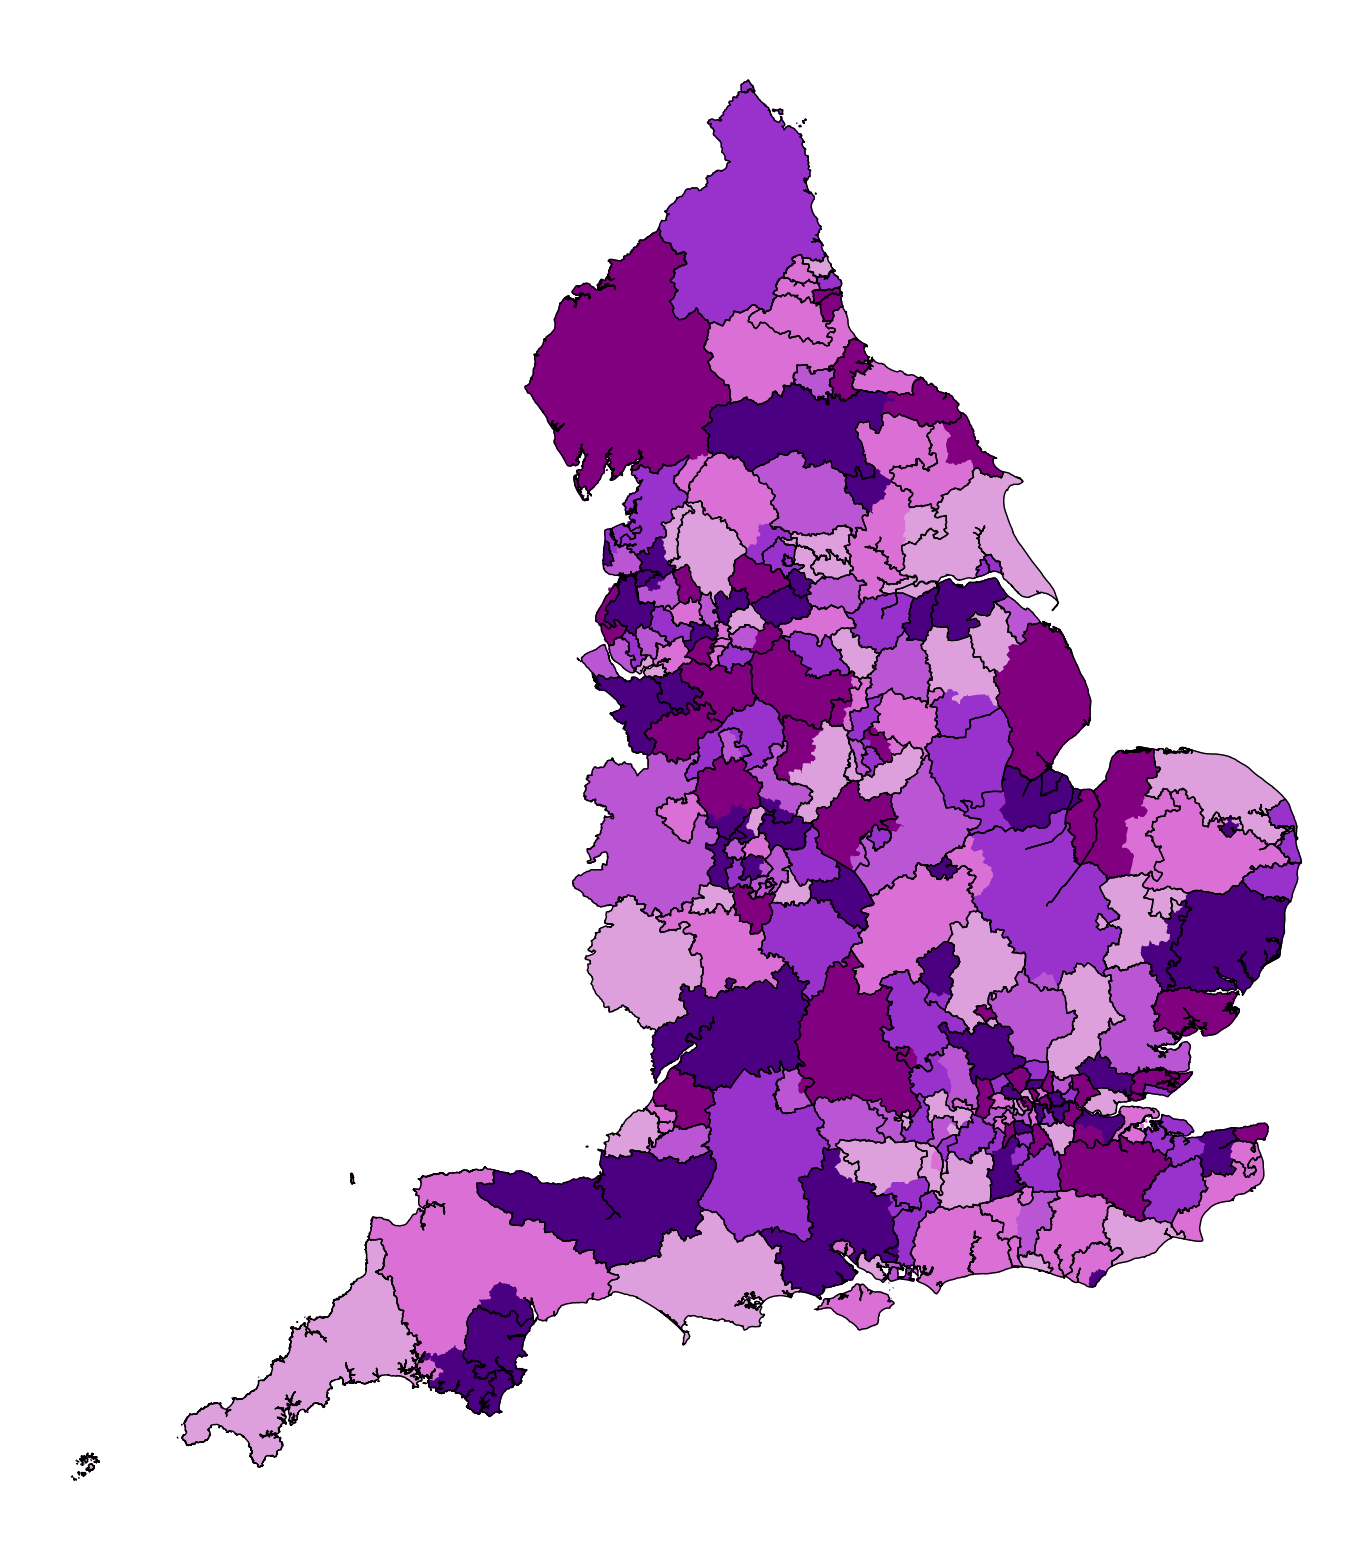

In [52]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_lsoa_glob.plot(ax=ax, edgecolor='face', facecolor=gdf_lsoa_glob['colour_str'])
gdf_ccg.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')

plt.savefig(os.path.join(paths.dir_output_images, paths.image_output), bbox_inches='tight')
plt.show()